# Import Libraries

In [176]:
# ! pip install missingno
# ! pip install cliffs_delta
# ! pip install category_encoders
# ! pip install xgboost

In [69]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
from cliffs_delta import cliffs_delta

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import missingno as msno

# Exploration

## Explore "userscore" table

In [2]:
# read table and show first 5 rows
userscore_df = pd.read_csv("data/userscore.csv")
userscore_df.head()

,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283
1,C_ID_3d0044924f,Jan-17,4,1,0,0.392913
2,C_ID_d639edf6cd,Aug-16,2,2,0,0.688056
3,C_ID_186d6a6901,Sep-17,4,3,0,0.142495
4,C_ID_cdbd2c0db2,Nov-17,1,3,0,-0.159749


In [3]:
# show some basic info.
userscore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   card_id             201917 non-null  object 
 1   first_active_month  201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   score               201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [4]:
userscore_df.describe(include="all")

,card_id,first_active_month,feature_1,feature_2,feature_3,score
count,201917,201917,201917.000000,201917.000000,201917.000000,201917.000000
unique,201917,75,NaN,NaN,NaN,NaN
top,C_ID_92a2005557,Sep-17,NaN,NaN,NaN,NaN
freq,1,13878,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.105311,1.745410,0.565569,-0.393636
std,NaN,NaN,1.186160,0.751362,0.495683,3.850500
min,NaN,NaN,1.000000,1.000000,0.000000,-33.219281
25%,NaN,NaN,2.000000,1.000000,0.000000,-0.883110
50%,NaN,NaN,3.000000,2.000000,1.000000,-0.023437
75%,NaN,NaN,4.000000,2.000000,1.000000,0.765453


In [5]:
# check missing values
userscore_df.isnull().any()

card_id               False
first_active_month    False
feature_1             False
feature_2             False
feature_3             False
score                 False
dtype: bool

In [6]:
# check duplicated data
print(f"Number fo dulicated rows: {userscore_df.duplicated().sum()}")

Number fo dulicated rows: 0


- As we can see the data is clean "no missing values" and there is no any duplicated rows

In [7]:
# print shape of data
userscore_df.shape

(201917, 6)

In [8]:
# show number of unique values in each column
userscore_df.nunique()

card_id               201917
first_active_month        75
feature_1                  5
feature_2                  3
feature_3                  2
score                 197110
dtype: int64

## Explore "merchants" table 

In [9]:
# read table and show first 5 rows
merchants_df = pd.read_csv("data/merchants.csv")
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [10]:
merchants_df.describe(include="all")

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696,334696,334696,334683.000000,...,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696,334696.000000,334696.000000,322809.000000
unique,334633,NaN,NaN,NaN,NaN,NaN,2,5,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,M_ID_42697d5d44,NaN,NaN,NaN,NaN,NaN,N,E,E,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,327657,177104,175309,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,238596,NaN,NaN,NaN
mean,NaN,31028.736143,423.131663,25.116404,0.011476,0.008103,NaN,NaN,NaN,13.832993,...,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,NaN,102.917926,11.860942,2.380002
std,NaN,31623.043426,252.898046,9.807371,1.098154,1.070497,NaN,NaN,NaN,2395.489999,...,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,NaN,107.090673,6.176889,1.562661
min,NaN,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,NaN,NaN,NaN,-82.130000,...,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,NaN,-1.000000,-1.000000,1.000000
25%,NaN,3612.000000,222.000000,19.000000,-0.057471,-0.057471,NaN,NaN,NaN,0.880000,...,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,NaN,-1.000000,9.000000,1.000000
50%,NaN,19900.000000,373.000000,27.000000,-0.057471,-0.057471,NaN,NaN,NaN,1.000000,...,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,NaN,69.000000,9.000000,2.000000
75%,NaN,51707.250000,683.000000,33.000000,-0.047556,-0.047556,NaN,NaN,NaN,1.160000,...,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,NaN,182.000000,16.000000,4.000000


In [11]:
# show some basic info.
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [12]:
# check missing values
merchants_df.isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

- There are some columns that have missing values ("avg_sales_lag3", "avg_sales_lag6", "avg_sales_lag12", "category_2").

In [13]:
# print shape of data
merchants_df.shape

(334696, 22)

In [14]:
# check duplicated data
print(f"Number fo dulicated rows: {merchants_df.duplicated().sum()}")

Number fo dulicated rows: 0


In [15]:
# show number of unique values in each column
merchants_df.nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       954
numerical_2                       947
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3372
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4507
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5009
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

- There is no complet duplicated rows, but merchant_id should have unique values equal to number of dataframe rows.
- We will remove duplicated merchant data.

In [16]:
# print number of duplicated rows
duplicated_rows = merchants_df["merchant_id"].duplicated().sum()
print(f"Number of duplicated merchant_ids: {duplicated_rows}")

# extract duplicated rows
mask = merchants_df["merchant_id"].duplicated()
merchants_df[mask].head(10)

Number of duplicated merchant_ids: 63


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
54,M_ID_c0b712e11a,35,823,25,-0.007896,-0.007896,N,E,E,1.01,...,1.01,1.097119,6,1.20,1.190741,12,N,231,9,1.0
112,M_ID_0039220eb3,35,836,5,0.408530,0.408530,Y,C,D,1.17,...,1.17,1.087939,6,1.19,0.997021,12,Y,-1,-1,NaN
3393,M_ID_bd49e37dda,4170,692,21,-0.057471,-0.057471,N,E,E,60.09,...,104.82,13.800000,5,104.82,13.800000,5,N,51,16,1.0
3394,M_ID_bd49e37dda,35,692,21,-0.057471,-0.057471,N,D,E,1.35,...,1.23,1.546667,6,1.23,1.546667,6,N,51,16,1.0
3395,M_ID_bd49e37dda,4170,692,21,-0.057471,-0.057471,N,D,E,1.35,...,1.23,1.546667,6,1.23,1.546667,6,N,51,16,1.0
4182,M_ID_ef233cff26,28799,560,34,-0.047556,-0.057471,N,E,E,322.44,...,817.53,162.055556,6,778.20,149.592593,9,Y,69,9,1.0
4183,M_ID_ef233cff26,28799,560,34,-0.057471,-0.057471,N,D,D,4.74,...,4.98,4.174242,6,4.25,3.509740,8,Y,69,9,1.0
4184,M_ID_ef233cff26,35,560,34,-0.057471,-0.057471,N,D,D,4.74,...,4.98,4.174242,6,4.25,3.509740,8,Y,69,9,1.0
7585,M_ID_dbbf07ebf0,35,278,37,-0.057471,-0.057471,N,E,E,52.08,...,75.36,68.000000,6,82.95,70.450000,10,Y,17,22,4.0
7586,M_ID_dbbf07ebf0,69462,278,37,-0.047556,-0.047556,N,D,D,1.12,...,1.23,1.234043,6,1.30,1.312500,12,Y,17,22,4.0


In [17]:
# drop duplicated
merchants_df.drop_duplicates(subset=["merchant_id"], inplace=True)

In [18]:
# check shape after removing duplication
merchants_df.shape

(334633, 22)

## Explore "historical_transactions" table

In [19]:
# read table and show first 5 rows
historical_transactions_df = pd.read_csv("data/historical_transactions.csv")
historical_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [20]:
# show some basic info.
historical_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [21]:
historical_transactions_df.describe(include="all")

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
count,29112361,29112361,2.911236e+07,29112361,2.911236e+07,28934202,2.911236e+07,28973880,2.911236e+07,2.911236e+07,29112361,2.645950e+07,2.911236e+07,2.911236e+07
unique,2,325540,NaN,2,NaN,3,NaN,326311,NaN,NaN,16395300,NaN,NaN,NaN
top,Y,C_ID_3d3dfdc692,NaN,N,NaN,A,NaN,M_ID_00a6ca8a8a,NaN,NaN,2017-11-24 00:00:00,NaN,NaN,NaN
freq,26595452,5582,NaN,27028332,NaN,15411747,NaN,1115097,NaN,NaN,26184,NaN,NaN,NaN
mean,NaN,NaN,1.293256e+02,NaN,6.484954e-01,NaN,4.810130e+02,NaN,-4.487294e+00,3.640090e-02,NaN,2.194578e+00,1.056679e+01,2.684839e+01
std,NaN,NaN,1.042563e+02,NaN,2.795577e+00,NaN,2.493757e+02,NaN,3.588800e+00,1.123522e+03,NaN,1.531896e+00,6.366927e+00,9.692793e+00
min,NaN,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.300000e+01,-7.469078e-01,NaN,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,NaN,NaN,5.300000e+01,NaN,0.000000e+00,NaN,3.070000e+02,NaN,-7.000000e+00,-7.203559e-01,NaN,1.000000e+00,9.000000e+00,1.900000e+01
50%,NaN,NaN,9.000000e+01,NaN,0.000000e+00,NaN,4.540000e+02,NaN,-4.000000e+00,-6.883495e-01,NaN,1.000000e+00,9.000000e+00,2.900000e+01
75%,NaN,NaN,2.120000e+02,NaN,1.000000e+00,NaN,7.050000e+02,NaN,-2.000000e+00,-6.032543e-01,NaN,3.000000e+00,1.600000e+01,3.400000e+01


In [22]:
# print number of rows and columns
historical_transactions_df.shape

(29112361, 14)

In [23]:
# check missing values
historical_transactions_df.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

- There are some columns that have missing values ("category_3", "merchant_id", "category_2").

In [24]:
# check duplicated data
print(f"Number fo dulicated rows: {historical_transactions_df.duplicated().sum()}")

Number fo dulicated rows: 0


In [25]:
# show number of unique values in each column
historical_transactions_df.nunique()

authorized_flag                2
card_id                   325540
city_id                      308
category_1                     2
installments                  15
category_3                     3
merchant_category_id         327
merchant_id               326311
month_lag                     14
purchase_amount           215014
purchase_date           16395300
category_2                     5
state_id                      25
subsector_id                  41
dtype: int64

## Explore "new_merchant_transactions" table

In [26]:
# read table and show first 5 rows
new_merchant_transactions_df = pd.read_csv("data/new_merchant_transactions.csv")
new_merchant_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [27]:
# show some basic info.
new_merchant_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


In [28]:
new_merchant_transactions_df.describe(include="all")

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
count,1963031,1963031,1.963031e+06,1963031,1.963031e+06,1907109,1.963031e+06,1936815,1.963031e+06,1.963031e+06,1963031,1.851286e+06,1.963031e+06,1.963031e+06
unique,1,290001,NaN,2,NaN,3,NaN,226129,NaN,NaN,1667025,NaN,NaN,NaN
top,Y,C_ID_b7ebee6539,NaN,N,NaN,A,NaN,M_ID_00a6ca8a8a,NaN,NaN,2017-11-18 00:00:00,NaN,NaN,NaN
freq,1963031,109,NaN,1899935,NaN,922244,NaN,23018,NaN,NaN,582,NaN,NaN,NaN
mean,NaN,NaN,1.343867e+02,NaN,6.829643e-01,NaN,4.309701e+02,NaN,1.476515e+00,-5.509690e-01,NaN,2.197841e+00,1.088067e+01,2.597624e+01
std,NaN,NaN,1.015152e+02,NaN,1.584069e+00,NaN,2.463385e+02,NaN,4.994483e-01,6.940043e-01,NaN,1.528125e+00,6.038542e+00,1.012908e+01
min,NaN,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,1.000000e+00,-7.468928e-01,NaN,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,NaN,NaN,6.900000e+01,NaN,0.000000e+00,NaN,2.780000e+02,NaN,1.000000e+00,-7.166294e-01,NaN,1.000000e+00,9.000000e+00,1.900000e+01
50%,NaN,NaN,1.100000e+02,NaN,1.000000e+00,NaN,3.670000e+02,NaN,1.000000e+00,-6.748406e-01,NaN,1.000000e+00,9.000000e+00,2.900000e+01
75%,NaN,NaN,2.120000e+02,NaN,1.000000e+00,NaN,6.830000e+02,NaN,2.000000e+00,-5.816162e-01,NaN,3.000000e+00,1.500000e+01,3.400000e+01


In [29]:
# print number of rows and columns
new_merchant_transactions_df.shape

(1963031, 14)

In [30]:
# check missing values
new_merchant_transactions_df.isnull().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

- There are some columns that have missing values ("category_3", "merchant_id", "category_2").

In [31]:
# check duplicated data
print(f"Number fo dulicated rows: {new_merchant_transactions_df.duplicated().sum()}")

Number fo dulicated rows: 0


In [32]:
# show number of unique values in each column
new_merchant_transactions_df.nunique()

authorized_flag               1
card_id                  290001
city_id                     308
category_1                    2
installments                 15
category_3                    3
merchant_category_id        314
merchant_id              226129
month_lag                     2
purchase_amount           75190
purchase_date           1667025
category_2                    5
state_id                     25
subsector_id                 41
dtype: int64

## General Exploration On Transactions Tables

- We will collect "historical_transactions", "new_merchant_transactions" together.

In [33]:
# check columns consistency
print(f"Number of consistent columns: {(historical_transactions_df.columns == new_merchant_transactions_df.columns).sum()}")

Number of consistent columns: 14


In [34]:
# concate two merchant transaction  tables together
transaction_df = pd.concat([historical_transactions_df, new_merchant_transactions_df])
transaction_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [35]:
# show basic info
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31075392 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 3.5+ GB


In [36]:
# show basic statistics
transaction_df.describe(include="all")

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
count,31075392,31075392,3.107539e+07,31075392,3.107539e+07,30841311,3.107539e+07,30910695,3.107539e+07,3.107539e+07,31075392,2.831078e+07,3.107539e+07,3.107539e+07
unique,2,325540,NaN,2,NaN,3,NaN,334633,NaN,NaN,17717516,NaN,NaN,NaN
top,Y,C_ID_3d3dfdc692,NaN,N,NaN,A,NaN,M_ID_00a6ca8a8a,NaN,NaN,2017-11-24 00:00:00,NaN,NaN,NaN
freq,28558483,5582,NaN,28928267,NaN,16333991,NaN,1138115,NaN,NaN,26727,NaN,NaN,NaN
mean,NaN,NaN,1.296453e+02,NaN,6.506728e-01,NaN,4.778518e+02,NaN,-4.110560e+00,-7.032267e-04,NaN,2.194792e+00,1.058662e+01,2.679329e+01
std,NaN,NaN,1.040926e+02,NaN,2.734985e+00,NaN,2.494821e+02,NaN,3.766495e+00,1.087456e+03,NaN,1.531650e+00,6.347145e+00,9.723248e+00
min,NaN,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.300000e+01,-7.469078e-01,NaN,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,NaN,NaN,5.300000e+01,NaN,0.000000e+00,NaN,3.020000e+02,NaN,-7.000000e+00,-7.199051e-01,NaN,1.000000e+00,9.000000e+00,1.900000e+01
50%,NaN,NaN,9.000000e+01,NaN,0.000000e+00,NaN,4.540000e+02,NaN,-3.000000e+00,-6.875230e-01,NaN,1.000000e+00,9.000000e+00,2.900000e+01
75%,NaN,NaN,2.120000e+02,NaN,1.000000e+00,NaN,7.050000e+02,NaN,-1.000000e+00,-6.008651e-01,NaN,3.000000e+00,1.600000e+01,3.400000e+01


In [37]:
# check duplicated rows
print(f"Number fo duplicated rows: {transaction_df.duplicated().sum()}")

Number fo duplicated rows: 0


In [38]:
# print count of missing values each column
transaction_df.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               234081
merchant_category_id          0
merchant_id              164697
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2764609
state_id                      0
subsector_id                  0
dtype: int64

- We will focus on the quality of the dataset, considering missing values, missing value patterns, missing value mechanism in ("category_3", "category_2"), and noise (e.g., consistency).

/opt/conda/lib/python3.9/site-packages/matplotlib/image.py:180: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


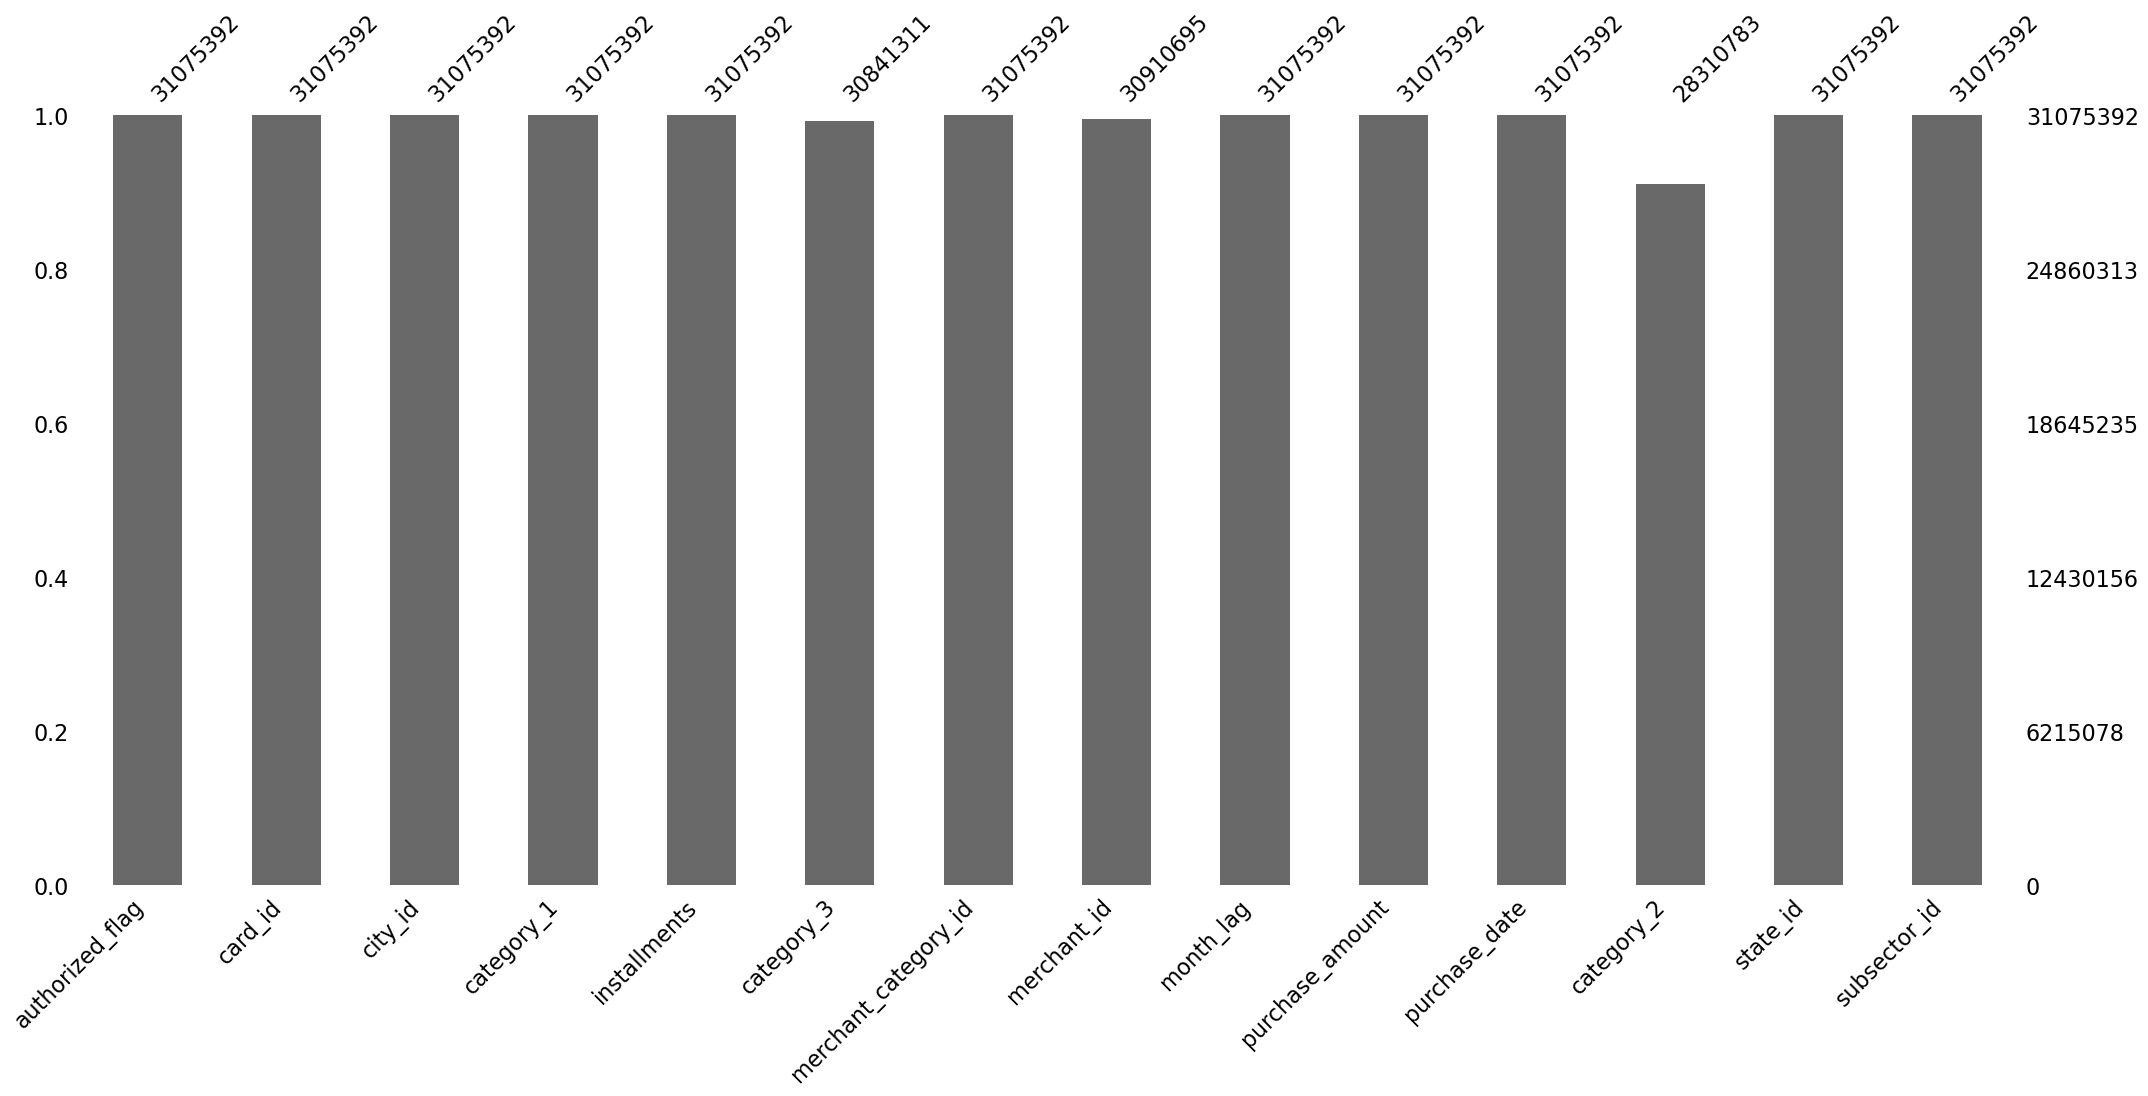

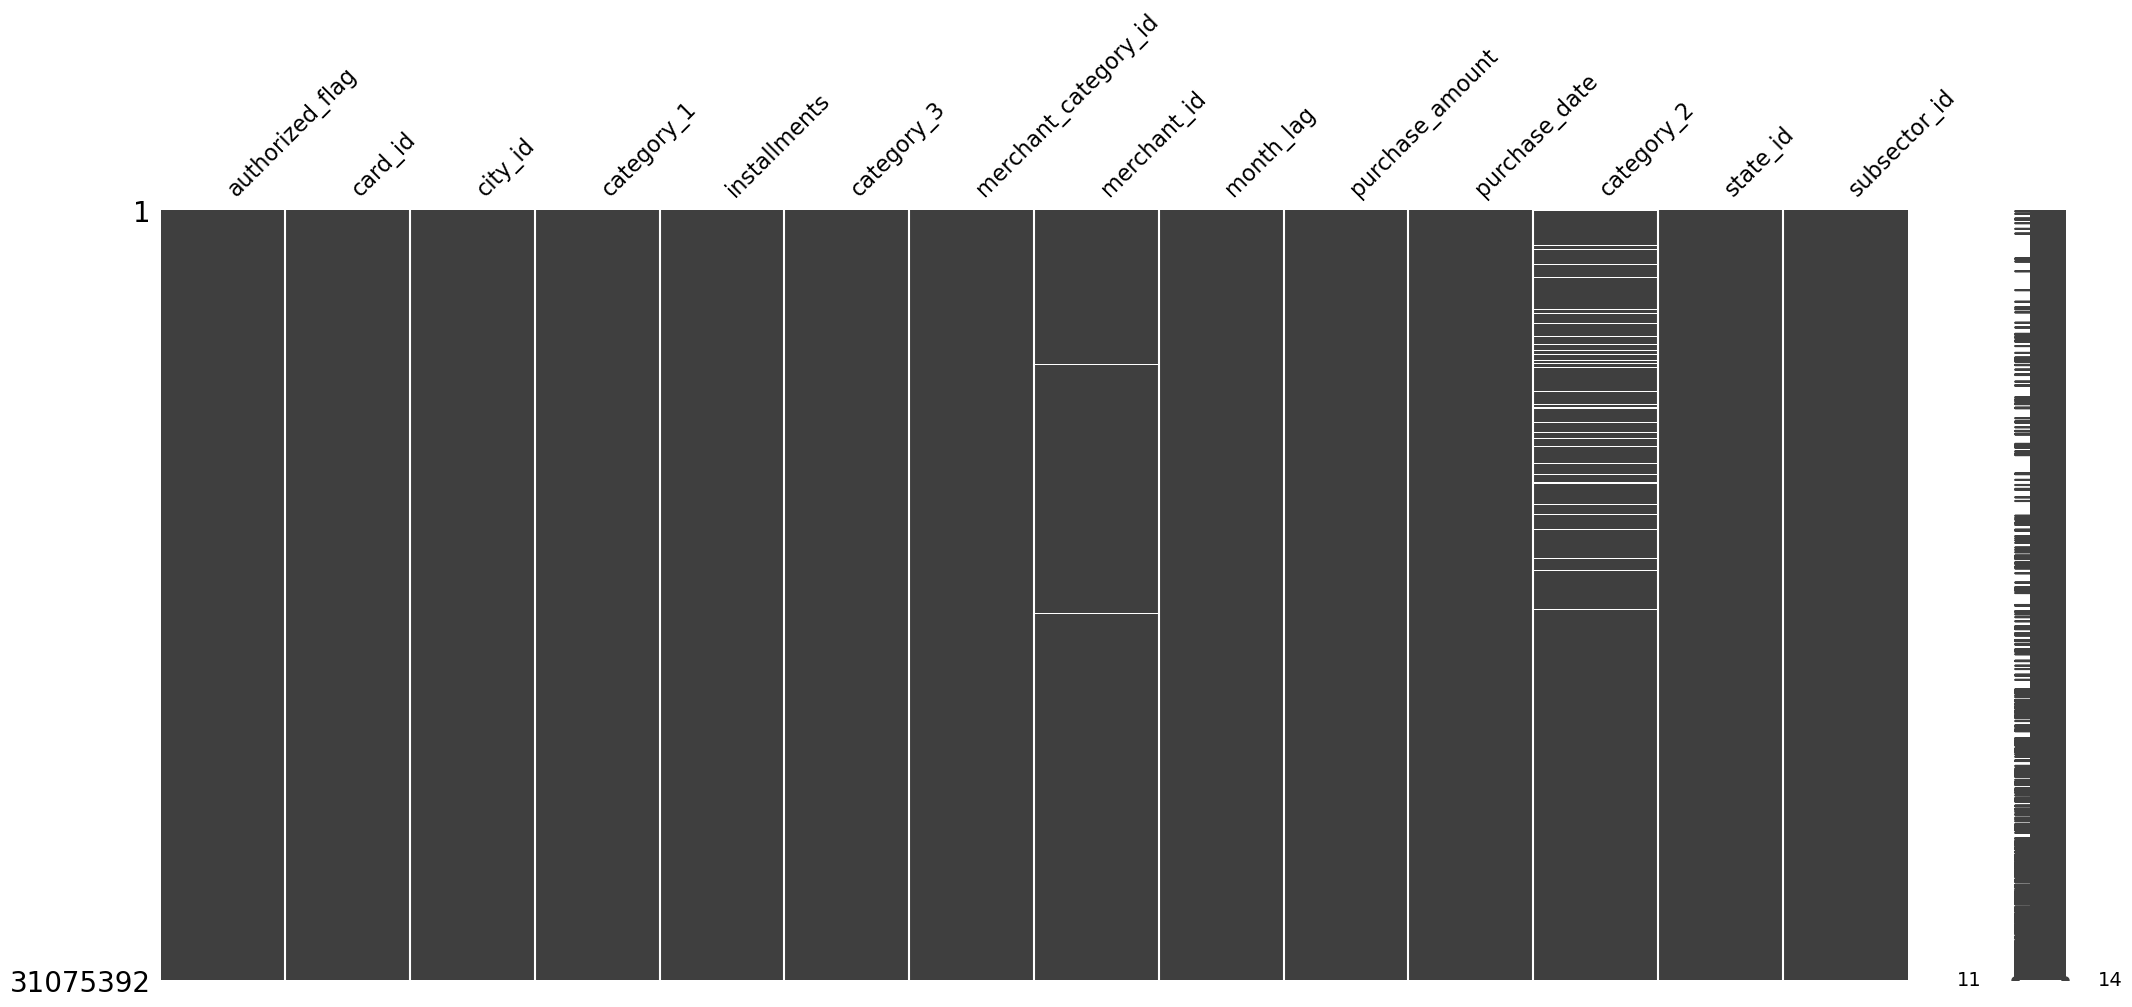

In [39]:
# Visualize the missing values pattern using missingno's bar function
msno.bar(transaction_df);

# Visualize the missing values pattern using missingno's matrix function
msno.matrix(transaction_df);

- Missing Patterns:
    - As we can see from the above visualizations the feature "category_2" has the larges number of missing values, but the distribution of missing values in these features is random comparing with other features, so I think all patterns of misssing values in ("category_3", "category_2") are "General Patterns".

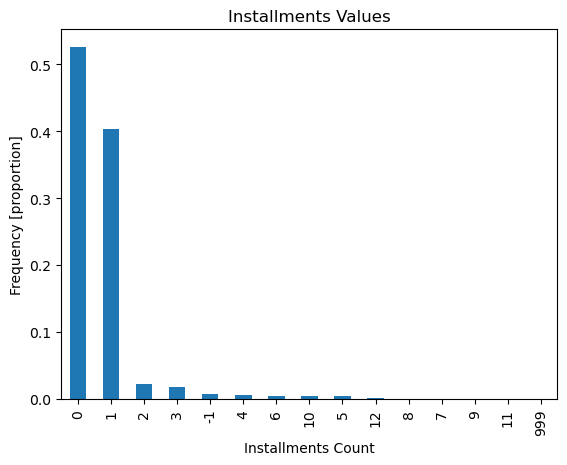

In [40]:
# detect noise in "installments" feature
transaction_df["installments"].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Installments Count")
plt.ylabel("Frequency [proportion]")
plt.title("Installments Values");

- There are some noise in "Installments" feature they are: (-1, 999).

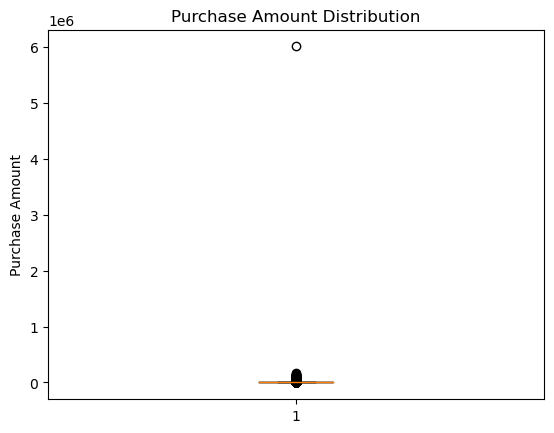

In [41]:
# visualize the "purchase_amount" distribution
plt.boxplot(transaction_df["purchase_amount"])
plt.ylabel("Purchase Amount")
plt.title("Purchase Amount Distribution");

- As we can see above the feature "purchase_amount" has outliers (noise), that we need to deal with in the cleaning step.

In [62]:
# show the relationship between noise and specific values of some features with missing values in the two columns ("category_3", "category_2")
x = transaction_df.copy()

# remove denied transactions
x = x[x["authorized_flag"] == "N"]

# remove outliers (noise) from "installments"
mask = (x["installments"] != -1) & (x["installments"] != 999)
x = x[mask]

# remove outliers from "purchase_amount"
clib = x["purchase_amount"].quantile(0.99)
x = x[x["purchase_amount"] < clib]

# remove negative values from "city_id" and "state_id"
x = x[x["city_id"] != -1]
x = x[x["state_id"] != -1]

x.isnull().sum()

authorized_flag             0
card_id                     0
city_id                     0
category_1                  0
installments                0
category_3                  0
merchant_category_id        0
merchant_id             14877
month_lag                   0
purchase_amount             0
purchase_date               0
category_2                  0
state_id                    0
subsector_id                0
dtype: int64

- Potential Missing Reason:
    - As we can see the missing values disappear when we removed specific values in som another features.
    - So missing values in the features ("category_2", "category_3") are dependent on values in some features, so we can say the mechanism here is "MAR".

# Data Cleaning

- We will remove noises from transactions tables that will lead to remove missing values in "category_3".
- We will use Mode Imputing to impute the rest of missing values in "category_2", and "merchant_id".

In [193]:
# function to read, clean and merge transactions tables
def process_trans(his_trans_path, new_trans_path):
    # concate two merchant transaction  tables together
    historical_transactions_df = pd.read_csv(his_trans_path)
    new_merchant_transactions_df = pd.read_csv(new_trans_path)
    transaction_df = pd.concat([historical_transactions_df, new_merchant_transactions_df])
    
    # remove the outlier(noise) from "purchase_amount" feature
    clib = transaction_df["purchase_amount"].quantile(0.99)
    transaction_df = transaction_df[transaction_df["purchase_amount"] < clib]
    
    # remove the noise from "installments"
    # this will remove missing values from "category_3" too
    mask = (transaction_df["installments"] != -1) & (transaction_df["installments"] != 999)
    transaction_df = transaction_df[mask]
    
    # convert purchase_date into datetime type(extract yyyy-mm-dd only) to reduce the cardinality
    transaction_df["purchase_date"] = pd.to_datetime(transaction_df["purchase_date"].str.split(" ", expand=True)[0])
    
    # drop low or high cardinality columns
    drop_list = ["category_1", "authorized_flag"]
    transaction_df.drop(columns=drop_list, inplace=True)
    
    # fill missing values using mode imputing
    transaction_df["category_2"].fillna(transaction_df["category_2"].mode()[0], inplace=True)
    transaction_df["merchant_id"].fillna(transaction_df["merchant_id"].mode()[0], inplace=True)
    
    # aggregate transactions table
    transaction_df = (
        transaction_df.
        groupby("card_id").
        agg(
            {
            "city_id": lambda x: x.value_counts().index[0], 
            "installments": "sum",
            "category_3": lambda x: x.value_counts().index[0],
            "merchant_category_id": lambda x: x.value_counts().index[0],
            "merchant_id": lambda x: x.value_counts().index[0],
            "month_lag": "sum",
            "purchase_amount": "sum",
            "purchase_date": "max",
            "category_2": lambda x: x.value_counts().index[0],
            "state_id": lambda x: x.value_counts().index[0],
            "subsector_id": lambda x: x.value_counts().index[0]
            }
        )
    )
    
    # reset card_id as a column
    transaction_df.reset_index(inplace=True)
    
    return transaction_df

In [194]:
# function to read and clean "merchant" table
def process_merch(merch_path):
    # read merchant table as a DataFrame
    merchants_df = pd.read_csv(merch_path)
   
    # drop duplicated
    merchants_df.drop_duplicates(subset=["merchant_id"], inplace=True)
    
    # drop columns that are common in transactions tables
    drop_list = ["merchant_group_id", "merchant_category_id", "subsector_id", "category_1", "city_id", "state_id", "category_2"]
    
    # drop columns with high or low cardinality
    drop_list.append("category_4")
    
    # remove columns in drop_list
    merchants_df.drop(columns=drop_list, inplace=True)
    
    # fill missing values with mean
    merchants_df["avg_sales_lag3"].fillna(merchants_df["avg_sales_lag3"].mean(), inplace=True)
    merchants_df["avg_sales_lag6"].fillna(merchants_df["avg_sales_lag6"].mean(), inplace=True)
    merchants_df["avg_sales_lag12"].fillna(merchants_df["avg_sales_lag12"].mean(), inplace=True)
    

    
    
    return merchants_df

In [195]:
# function to read and clean userscore data
def process_userscore(userscore_path):
    # read merchant table as a DataFrame
    userscore_df = pd.read_csv(userscore_path, index_col="card_id")
    
    # drop low or high cardinality
    userscore_df.drop("feature_3", axis=1, inplace=True)
    
    return userscore_df
    
    

In [196]:
# function to join tables together
def join_tables(df1, df2, com_col):
    # Join the dataframes on the com_col
    df_joined = pd.merge(df1, df2, on=com_col, how='inner')

    return df_joined

In [197]:
# function to wrangle data
def wrangle(files_paths, include_all=True):
    # concate two merchant transaction  tables together
    transaction_df = process_trans(files_paths["historical_transactions"], files_paths["new_transactions"])
    
    if include_all:
        # read merchant table as a DataFrame
        merchants_df = process_merch(files_paths["merchants"])
        # join transaction_df with merchants_df
        transaction_df = join_tables(transaction_df, merchants_df, "merchant_id")
    
    # read and clean userscore table
    userscore_df = process_userscore(files_paths["userscores"])
    
    # join data with userscore table
    df = join_tables(transaction_df, userscore_df, "card_id")
    
    # drop columns with high cardinality
    df.drop(columns=["card_id", "merchant_id"], inplace=True)
    
    return df

In [198]:
files_paths = {
            "historical_transactions": "data/historical_transactions.csv", 
            "new_transactions": "data/new_merchant_transactions.csv", 
            "merchants": "data/merchants.csv", 
            "userscores": "data/userscore.csv"
}

- Clean and read all tables together ("historical_transactions", "new_merchant_transactions", "merchants", "userscore").

In [200]:
df = wrangle(files_paths)
# save joined table(with all four tables)
df.to_csv("data/joined_all_tables.csv", index=False)

- Clean and read tables together ("historical_transactions", "new_merchant_transactions", "userscore").

In [201]:
df = wrangle(files_paths, include_all=False)
# save joined table(except "merchant" table)
df.to_csv("data/joined_tables.csv", index=False)

# Statistics and Hypothesis Test

Note: We will use in this hypothesis tests the data that are collected from the three tables ("historical_transactions", "new_merchant_transactions", "userscore").

- Check the normality of the target variable, i.e., 'score', using both graphical and statistical test methods.

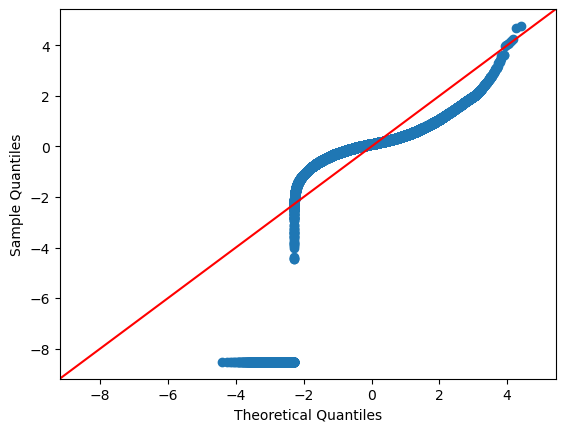

/tmp/ipykernel_99/2774953041.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, ax=axes[0])


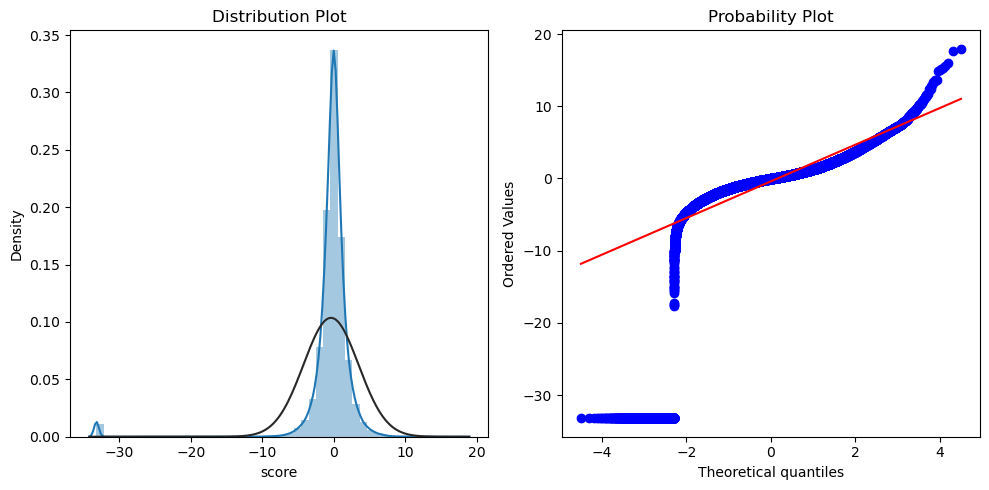

In [202]:
# Let's check if the points of "score" have been sampled from a normal distribution. 
# Let's try graphical methods first, using QQ plot. 


#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(df["score"], line='45', fit = True)
plt.show()


# another way to perform graphical method.
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')
    #`probplot` generates a probability plot, which should not be confused with a Q-Q or a P-P plot.
    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

normality_plot(df["score"])

In [203]:
#seems that the "score" does not follow normal distribution, let's perform statistical test.
# Shapiro-wilk test
w, pvalue = stats.shapiro(df["score"]) #if p-value obtained from the Shapiro-Wilk test is significant (p < 0.05), we conclude that the data is not normally distribute
print("p = {:g}".format(pvalue))

# D’Agostino-Pearson’s K² test, ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
k2, p = stats.normaltest(df["score"])
print("p = {:g}".format(p))

alpha = 1e-3
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0
p = 0
The null hypothesis can be rejected


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


- We conclude from the above notes that "score" data points may not be came from a normal distribution.

Check the normality of "purchase_amount", using graphical method.

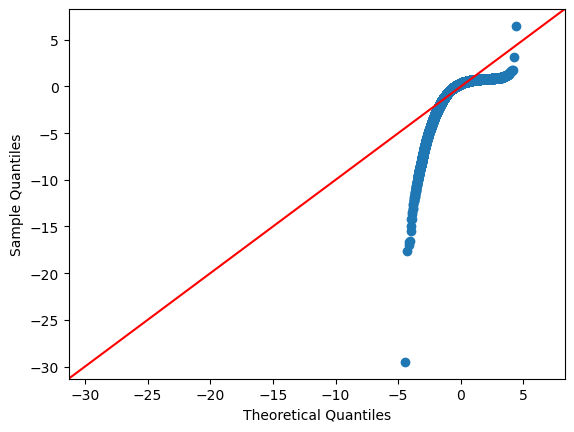

/tmp/ipykernel_99/3677130284.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, ax=axes[0])


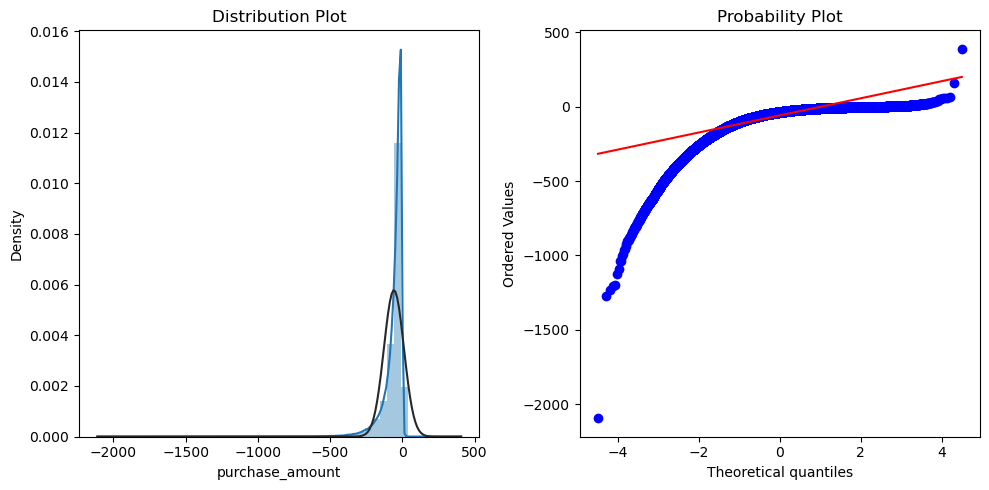

In [204]:
# Let's check if the points of "purchase_amount" have been sampled from a normal distribution. 
# Let's try graphical methods first, using QQ plot. 


#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(df["purchase_amount"], line='45', fit = True)
plt.show()


# another way to perform graphical method.
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')
    #`probplot` generates a probability plot, which should not be confused with a Q-Q or a P-P plot.
    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

normality_plot(df["purchase_amount"])

- We conclude from the above graphs that "purchase_amount" data points may not be came from a normal distribution.

### We will discuss two different hypothesis tests:

- hypothesis(1):
    - null_hypothesis: when the installments are large(>500) the loyality score doesn't be effected.
    - Alternative Hypothesis: when the installments are large(>500) the loyality score is large.
    - Motivation: illustrate the effectiveness of installments on loyality score.
    - Note: we aggregate(sum) the installments in cleaning phase so we got very large numbers of installments.

In [243]:
# get the "score" for Manhattan ("installments" > 500) and the "score" in elsewhere
manh_score = df.loc[df["installments"] > 500]["score"]
elsewhere_score = df.loc[df["installments"] <= 500]["score"]

#We can check if SALE PRICE in Manhattan is higher than elsewhere 
statistic, pvalue = stats.mannwhitneyu(x=manh_score, y=elsewhere_score, alternative = 'greater')

print("the p_value = {0:.5f}".format(pvalue))
if pvalue < 0.05: # significance level
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis can not be rejected")

the p_value = 0.99967
The null hypothesis can not be rejected


- We conclude that we can not reject that null_hypothesis: when the installments are big(>500) the loyality score doesn't be effected.

- hypothesis(2):
    - null_hypothesis: when the purchase_amount is large(>0 "normalized") the loyality score doesn't be effected.
    - Alternative Hypothesis: when the purchase_amount is large(>0) the loyality score is large.
    - Motivation: illustrate the effectiveness of purchase_amount that paid on loyality score.

In [244]:
# get the "score" for Manhattan ("installments" > 500) and the "score" in elsewhere
manh_score = df.loc[df["purchase_amount"] > 0]["score"]
elsewhere_score = df.loc[df["purchase_amount"] <= 0]["score"]

#We can check if SALE PRICE in Manhattan is higher than elsewhere 
statistic, pvalue = stats.mannwhitneyu(x=manh_score, y=elsewhere_score, alternative = 'greater')

print("the p_value = {0:.5f}".format(pvalue))
if pvalue < 0.05: # significance level
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis can not be rejected")

the p_value = 0.00001
The null hypothesis can be rejected


- We conclude that we can reject the null_hypothesis and accept the Alternative Hypothesis: when the purchase_amount is large(>0) the loyality score is large.

# Modeling Analysis

- We will try two different experiments.
- The first experiment will include all tables ("historical_transactions", "new_merchant_transactions", "merchants", "userscore").
- The second one will cover three tables only ("historical_transactions", "new_merchant_transactions", "userscore").

## Experiment(1):

- We will use all tables ("historical_transactions", "new_merchant_transactions", "merchants", "userscore").
- We will use the "Ridge" model.

In [206]:
# load data
df = pd.read_csv("data/joined_all_tables.csv")

# split the data into features and target
target = "score"
X = df.drop(columns=target)
y = df[target]

In [207]:
# split the data into training and testing randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

- we will use Ridge model with onehotencoder in our pipeline.

In [208]:
# show features that will be used
print("We will use these features:")
X_train.columns

We will use these features:


Index(['city_id', 'installments', 'category_3', 'merchant_category_id',
       'month_lag', 'purchase_amount', 'purchase_date', 'category_2',
       'state_id', 'subsector_id', 'numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'first_active_month', 'feature_1', 'feature_2'],
      dtype='object')

In [209]:
# build model
model_ex1_v1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

# train the model
model_ex1_v1.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['category_3', 'purchase_date',
                                     'most_recent_sales_range',
                                     'most_recent_purchases_range',
                                     'first_active_month'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [210]:
# evaluate the model on training data
y_pred_train = model_ex1_v1.predict(X_train)
print(f"RMSE on training data is: {round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2)}")

RMSE on training data is: 3.78


In [211]:
# evaluate the model on testing data
y_pred = model_ex1_v1.predict(X_test)
print(f"RMSE on testing data is: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

RMSE on testing data is: 3.87


- The evaluation metric seems to be a bit good, but we expect better results.

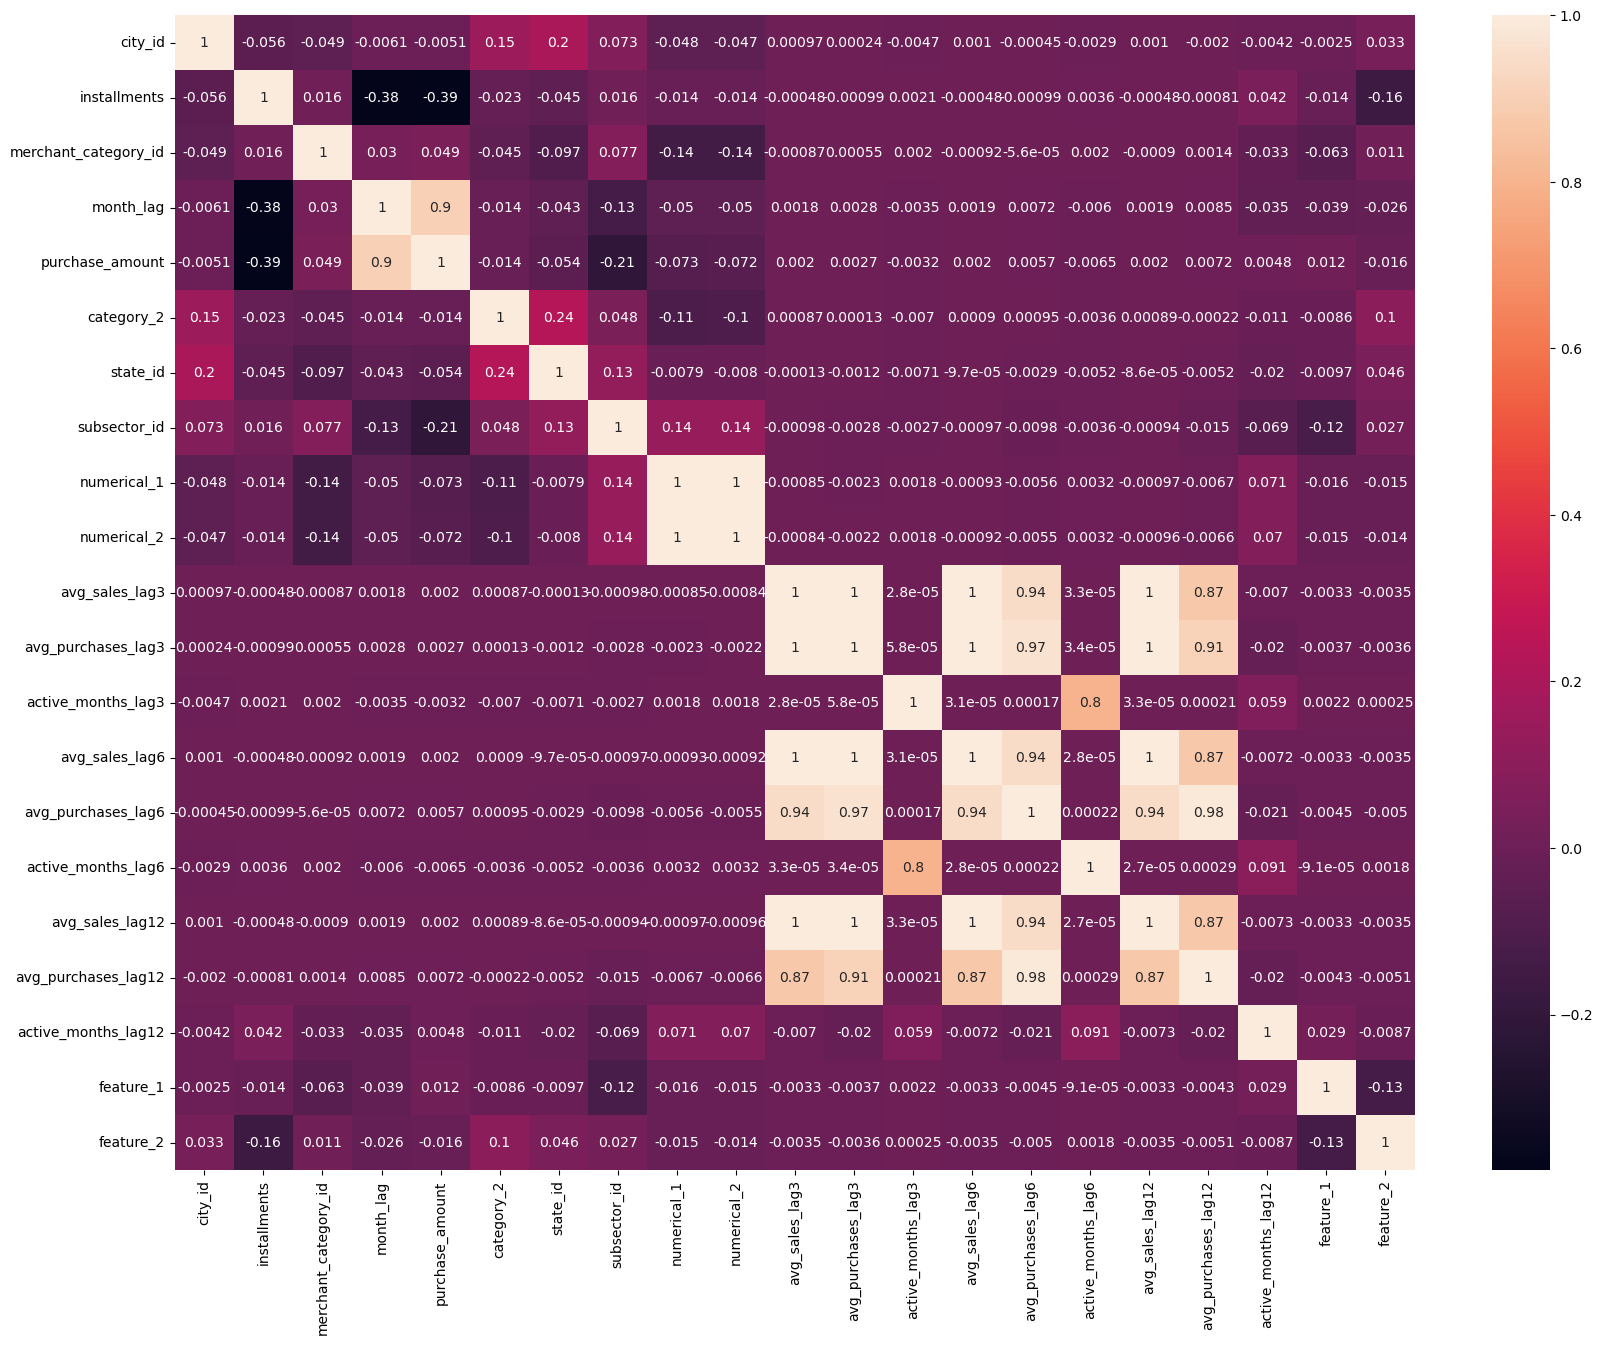

In [212]:
# detect multicolinearity
corr = X_train.select_dtypes("number").corr()
# create a larger figure using matplotlib
plt.figure(figsize=(20, 15))

sns.heatmap(corr, annot=True);

- As we can see there are many multicollinearity, were the features are correlated together.

In [213]:
# calculate the correlation matrix
corr = X_train.select_dtypes("number").corr().abs()
# create a boolean mask for identifying correlated columns
mask = corr > 0.3

# extract the column names of correlated columns
collinear_cols = set()
for i in range(len(mask.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            colname = mask.columns[i]
            collinear_cols.add(colname)

# print the correlated column names
print("Highly correlated features:")
print(collinear_cols)

Highly correlated features:
{'month_lag', 'avg_sales_lag6', 'avg_purchases_lag6', 'numerical_2', 'avg_purchases_lag12', 'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag3', 'purchase_amount'}


- We will drop these columns from our dataset

In [214]:
# remove highly correlated columns
X_train_nocor = X_train.drop(columns=collinear_cols)
X_test_nocor = X_test.drop(columns=collinear_cols)

In [215]:
# show features that will be used
print("We will use these features:")
X_train_nocor.columns

We will use these features:


Index(['city_id', 'installments', 'category_3', 'merchant_category_id',
       'purchase_date', 'category_2', 'state_id', 'subsector_id',
       'numerical_1', 'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'active_months_lag3', 'active_months_lag12',
       'first_active_month', 'feature_1', 'feature_2'],
      dtype='object')

In [216]:
# build model
model_ex1_v2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

# train the model
model_ex1_v2.fit(X_train_nocor, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['category_3', 'purchase_date',
                                     'most_recent_sales_range',
                                     'most_recent_purchases_range',
                                     'first_active_month'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [217]:
# evaluate the model on training data
y_pred_train = model_ex1_v2.predict(X_train_nocor)
exp1_eval_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2)
print(f"RMSE on training data is: {exp1_eval_train}")

RMSE on training data is: 3.78


In [218]:
# evaluate the model on testing data
y_pred = model_ex1_v2.predict(X_test_nocor)
exp1_eval_test = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
print(f"RMSE on testing data is: {exp1_eval_test}")

RMSE on testing data is: 3.87


- The results are not as we expect (remove multicollinearity, increase performance), but the model still generalizes well on testing data, it's about(RMSE = 3.87) not significantly different from training(RMSE = 3.78).

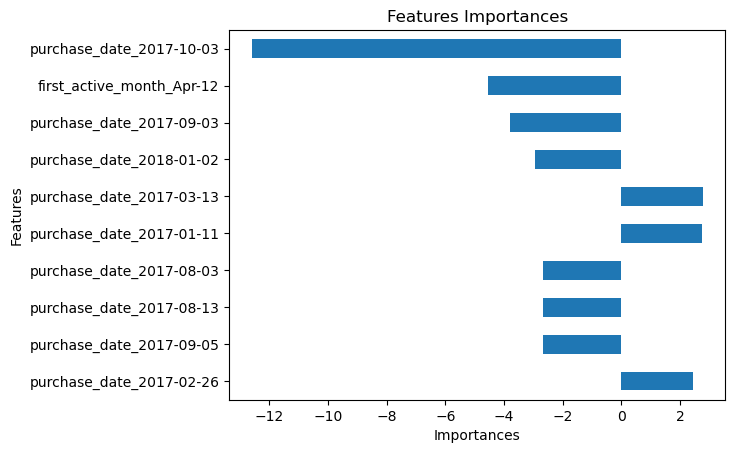

In [219]:
# visualize the features importances
feat = model_ex1_v2.named_steps["onehotencoder"].get_feature_names_out()
importances = model_ex1_v2.named_steps["ridge"].coef_
feat_import = pd.Series(importances, index=feat).sort_values(key=abs)

# visualize the features importances
feat_import.tail(10).plot(kind="barh")
plt.title("Features Importances")
plt.xlabel("Importances")
plt.ylabel("Features");

- As we can see people who have transactions on the "purchase_date: 2017-10-03", we expect they will get a low loyality score, as this feature has the highest negative coefficient.

## Experiment(2):

- We will use these tables only ("historical_transactions", "new_merchant_transactions", "userscore").
- We will use the "Ridge" model.

In [220]:
# load data
df = pd.read_csv("data/joined_tables.csv")

# split the data into features and target
target = "score"
X = df.drop(columns=target)
y = df[target]

In [221]:
# split the data into training and testing randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

- we will use Ridge model with onehotencoder in our pipeline.

In [222]:
# show features that will be used
print("We will use these features:")
X_train.columns

We will use these features:


Index(['city_id', 'installments', 'category_3', 'merchant_category_id',
       'month_lag', 'purchase_amount', 'purchase_date', 'category_2',
       'state_id', 'subsector_id', 'first_active_month', 'feature_1',
       'feature_2'],
      dtype='object')

In [223]:
# build model
model_ex2_v1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

# train the model
model_ex2_v1.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['category_3', 'purchase_date',
                                     'first_active_month'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [224]:
# evaluate the model on training data
y_pred_train = model_ex2_v1.predict(X_train)
print(f"RMSE on training data is: {round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2)}")

RMSE on training data is: 3.79


In [225]:
# evaluate the model on testing data
y_pred = model_ex2_v1.predict(X_test)
print(f"RMSE on testing data is: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

RMSE on testing data is: 3.84


- The evaluation metric seems to be better than experiment(1), but we expect better results.

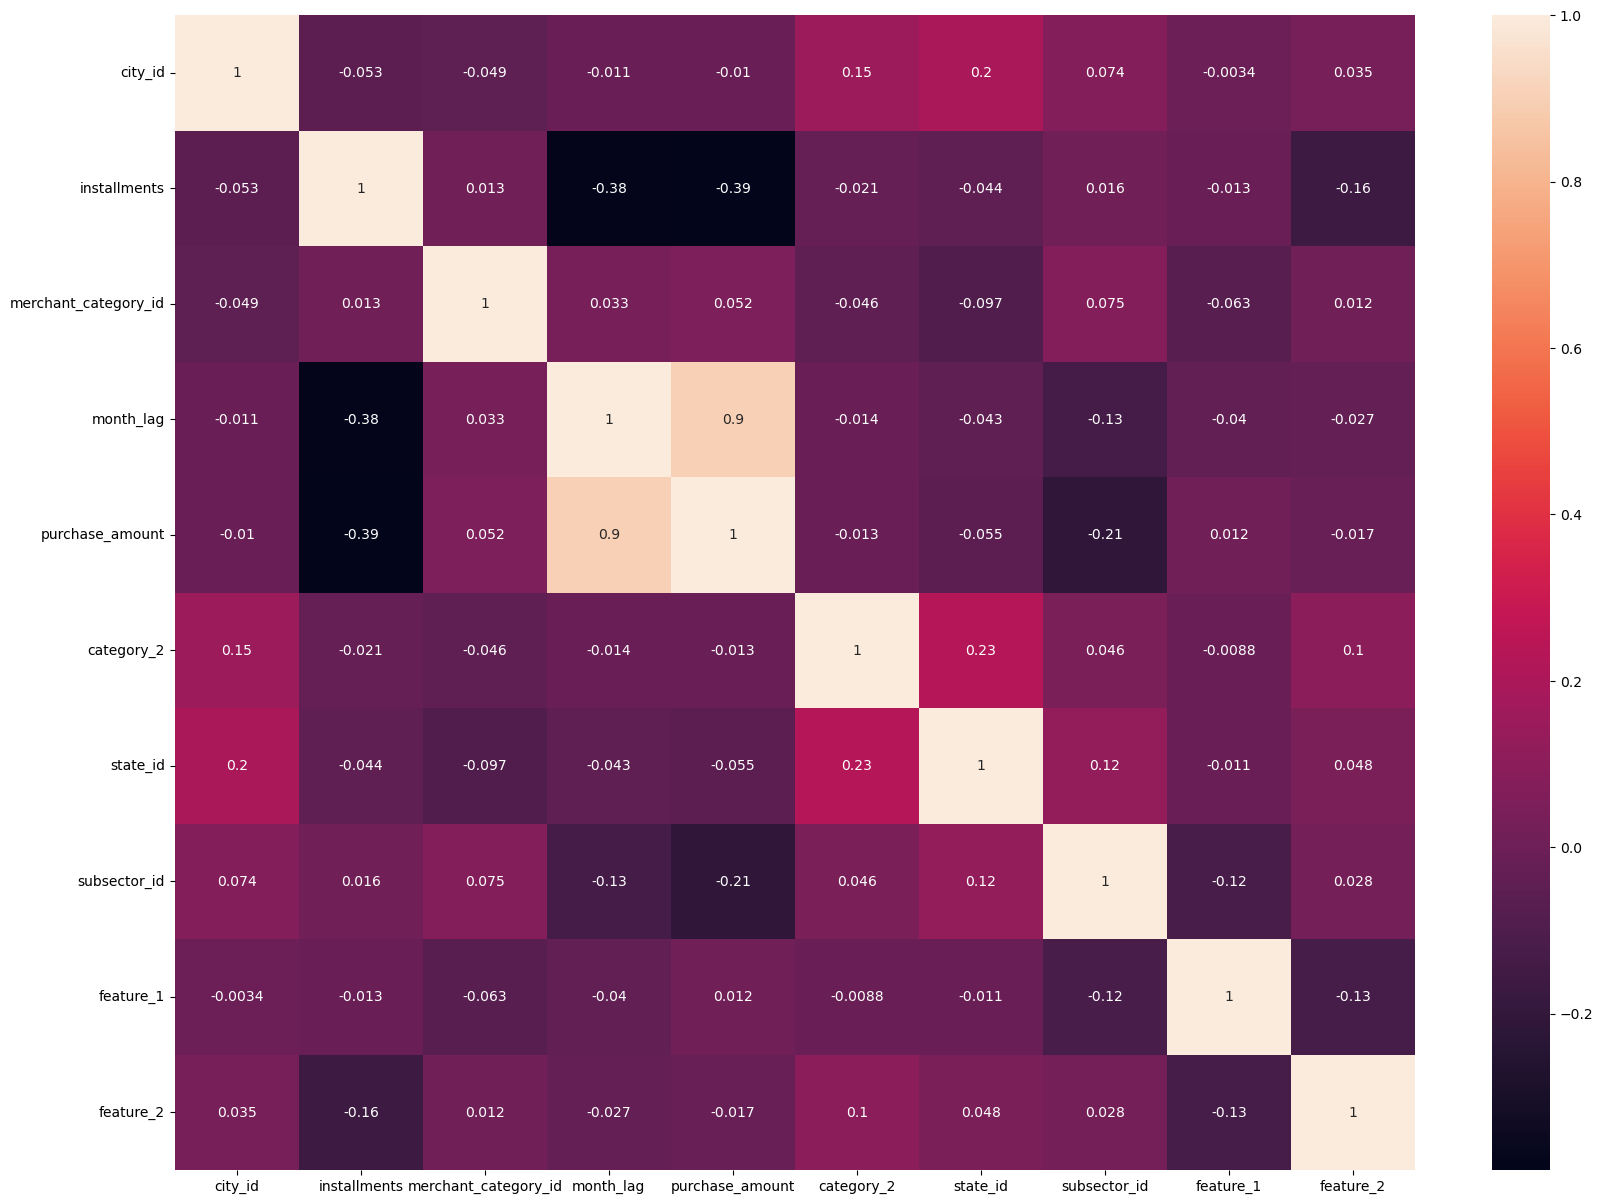

In [226]:
# detect multicolinearity
corr = X_train.select_dtypes("number").corr()
# create a larger figure using matplotlib
plt.figure(figsize=(20, 15))

sns.heatmap(corr, annot=True);

- As we can see there are some multicollinearity, were the features are correlated together.

In [227]:
# calculate the correlation matrix
corr = X_train.select_dtypes("number").corr().abs()
# create a boolean mask for identifying correlated columns
mask = corr > 0.3

# extract the column names of correlated columns
collinear_cols = set()
for i in range(len(mask.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            colname = mask.columns[i]
            collinear_cols.add(colname)

# print the correlated column names
print("Highly correlated features:")
print(collinear_cols)

Highly correlated features:
{'month_lag', 'purchase_amount'}


- We will drop these columns from our dataset.

In [228]:
# remove highly correlated columns
X_train_nocor = X_train.drop(columns=collinear_cols)
X_test_nocor = X_test.drop(columns=collinear_cols)

In [229]:
# show features that will be used
print("We will use these features:")
X_train_nocor.columns

We will use these features:


Index(['city_id', 'installments', 'category_3', 'merchant_category_id',
       'purchase_date', 'category_2', 'state_id', 'subsector_id',
       'first_active_month', 'feature_1', 'feature_2'],
      dtype='object')

In [230]:
# build model
model_ex2_v2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

# train the model
model_ex2_v2.fit(X_train_nocor, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['category_3', 'purchase_date',
                                     'first_active_month'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [231]:
# evaluate the model on training data
y_pred_train = model_ex2_v2.predict(X_train_nocor)
exp2_eval_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2)
print(f"RMSE on training data is: {exp2_eval_train}")

RMSE on training data is: 3.79


In [232]:
# evaluate the model on testing data
y_pred = model_ex2_v2.predict(X_test_nocor)
exp2_eval_test = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
print(f"RMSE on testing data is: {exp2_eval_test}")

RMSE on testing data is: 3.84


- The results are not as we expect (remove multicollinearity, increase performance), but the model still generalizes well on testing data, it's about(RMSE = 3.84) not significantly different from training(RMSE = 3.79).

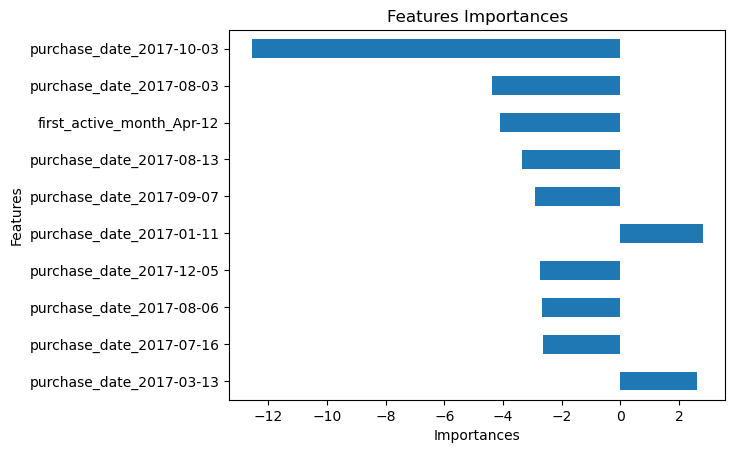

In [233]:
# visualize the features importances
feat = model_ex2_v2.named_steps["onehotencoder"].get_feature_names_out()
importances = model_ex2_v2.named_steps["ridge"].coef_
feat_import = pd.Series(importances, index=feat).sort_values(key=abs)

# visualize the features importances
feat_import.tail(10).plot(kind="barh")
plt.title("Features Importances")
plt.xlabel("Importances")
plt.ylabel("Features");

- As we can see people who have transactions on the "purchase_date: 2017-10-03", we expect they will get a low loyality score, as this feature has the highest negative coefficient.

- # We will compare the results when we used all tables and when we excepted "merchant" table

In [234]:
# list of scores of different trials(to save evaluations of different trails)
scores_list = pd.DataFrame()
# save exp1 evaluations
scores_list["score"] = [exp1_eval_train, exp1_eval_test, exp2_eval_train, exp2_eval_test]
scores_list["experiment"] = ["exp1", "exp1", "exp2", "exp2"]
scores_list["data_type"] = ["train", "test", "train", "test"]
scores_list

,score,experiment,data_type
0,3.78,exp1,train
1,3.87,exp1,test
2,3.79,exp2,train
3,3.84,exp2,test


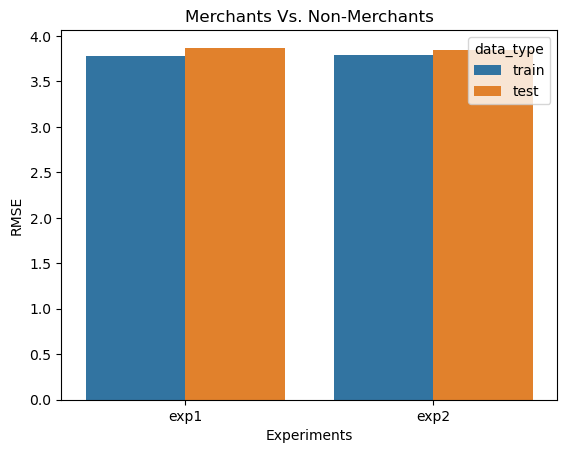

In [235]:
# visualize the difference between two experiments
sns.barplot(
    x=scores_list["experiment"],
    y=scores_list["score"],
    hue=scores_list["data_type"]
)
plt.title("Merchants Vs. Non-Merchants")
plt.ylabel("RMSE")
plt.xlabel("Experiments");

- As we can see the experiment2 results(without using Merchant table) is almost same as experiment1 results(using Merchant table).